## Kredi Kartı Sahtekarlık Tespiti - Model Eğitimi
### Bu notebook, kredi kartı sahtekarlık tespiti için çeşitli modellerin eğitilmesi sürecini içermektedir.

In [45]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

# Özel modüllerimizi import edelim
import sys
sys.path.append('..')  # Ana dizini ekleyelim

from src.utils.logger import setup_logger
from src.constants import TARGET, NUMERICAL_FEATURES, RANDOM_STATE, MODELS_DIR
from src.models.xgboost import train_xgboost, evaluate_xgboost
from src.models.logistic_regression import train_logistic_regression, evaluate_logistic_regression
from src.preprocessing.pipeline import FraudPreprocessor
from src.config import XGBOOST_PARAMS, LOGISTIC_REGRESSION_PARAMS

# Logger'ı ayarlayalım
logger = setup_logger("model_training_notebook")

In [46]:
# İşlenmiş eğitim ve test veri setlerini yükleyelim
processed_dir = '../data/processed/'

# Dengelenmiş eğitim setini yükleyelim (SMOTE + Undersampling uygulanmış)
balanced_train = pd.read_csv(f'{processed_dir}balanced_train.csv')
print(f"Dengelenmiş eğitim seti boyutu: {balanced_train.shape}")

# İşlenmiş test setini yükleyelim
processed_test = pd.read_csv(f'{processed_dir}processed_test.csv')
print(f"İşlenmiş test seti boyutu: {processed_test.shape}")

# Özellik ve hedef değişkenlere ayıralım
# Preprocessor'ı yükleyelim
with open('../models/preprocessing_pipeline.pkl', 'rb') as f:
    preprocessor = pickle.load(f)

# Eğitim seti
X_train, y_train = preprocessor.get_features_and_target(balanced_train)

# Test seti
X_test, y_test = preprocessor.get_features_and_target(processed_test)

print(f"Eğitim özellikleri: {X_train.shape}, Eğitim hedefleri: {y_train.shape}")
print(f"Test özellikleri: {X_test.shape}, Test hedefleri: {y_test.shape}")

Dengelenmiş eğitim seti boyutu: (68235, 41)


2025-05-03 18:16:40,441 | INFO | pipeline.py:110 | Splitting features and target
2025-05-03 18:16:40,450 | INFO | pipeline.py:110 | Splitting features and target


İşlenmiş test seti boyutu: (56962, 41)
Eğitim özellikleri: (68235, 40), Eğitim hedefleri: (68235,)
Test özellikleri: (56962, 40), Test hedefleri: (56962,)


# Modellerin Eğitilmesi ve Değerlendirilmesi
## XGBoost Modeli

2025-05-03 18:16:40,464 | INFO | 617186421.py:4 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:40,464 | INFO | 617186421.py:4 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:40,464 | INFO | 617186421.py:4 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:40,464 | INFO | 617186421.py:4 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:40,466 | INFO | base_model.py:29 | Initialized xgboost model
2025-05-03 18:16:40,466 | INFO | xgboost.py:31 | Training XGBoost model with 68235 samples
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:16:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
2025-05-03 18:16:42,215 | INFO | xgboost.py:63 | XGBoost model training completed
2025-05-03 18:16:42,219 | INFO | xgboost.py:71 | Making predictions on 68235 samples
2025-05


Eğitim Seti Performansı (XGBoost):
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test Seti Performansı (XGBoost):
Accuracy: 0.9990168884519505
Precision: 0.6615384615384615
Recall: 0.8775510204081632
F1 Score: 0.7543859649122807

Sınıflandırma Raporu (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.88      0.75        98

    accuracy                           1.00     56962
   macro avg       0.83      0.94      0.88     56962
weighted avg       1.00      1.00      1.00     56962



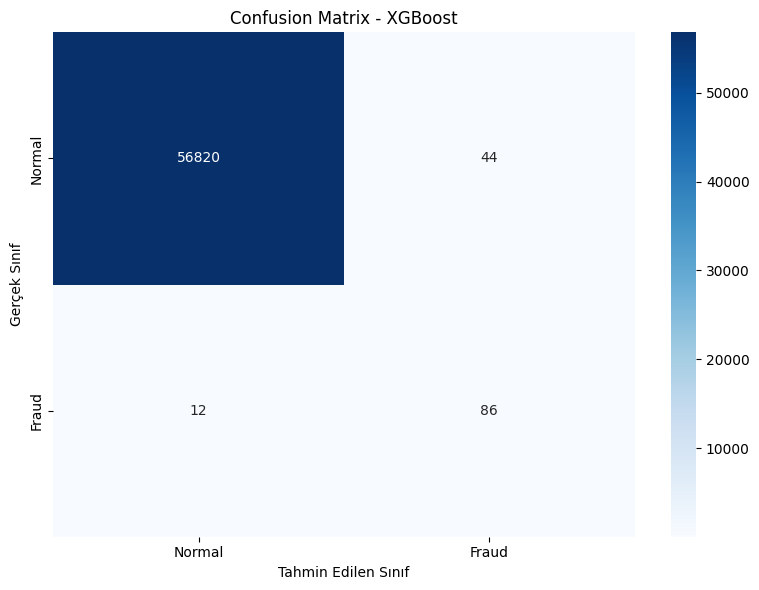

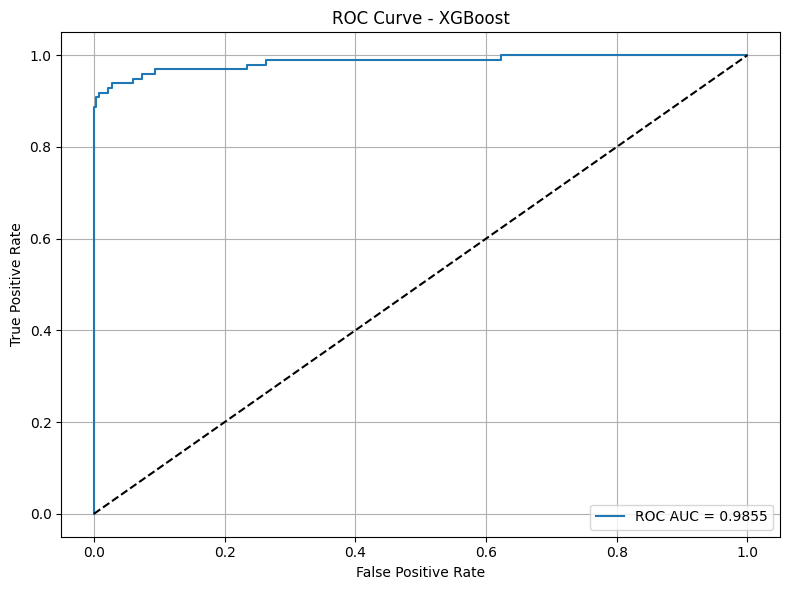

In [47]:
from sklearn.metrics import roc_auc_score


logger.info("XGBoost modeli eğitiliyor...")
xgb_model = train_xgboost(X_train, y_train, params=XGBOOST_PARAMS)

# Eğitim seti üzerinde değerlendirelim
train_probs_xgb = xgb_model.predict(X_train)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
train_preds_xgb = (train_probs_xgb >= 0.5).astype(int)

print("\nEğitim Seti Performansı (XGBoost):")
print("Accuracy:", accuracy_score(y_train, train_preds_xgb))
print("Precision:", precision_score(y_train, train_preds_xgb))
print("Recall:", recall_score(y_train, train_preds_xgb))
print("F1 Score:", f1_score(y_train, train_preds_xgb))

# Test seti üzerinde değerlendirelim
test_probs_xgb = xgb_model.predict(X_test)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
test_preds_xgb = (test_probs_xgb >= 0.5).astype(int)

print("\nTest Seti Performansı (XGBoost):")
print("Accuracy:", accuracy_score(y_test, test_preds_xgb))
print("Precision:", precision_score(y_test, test_preds_xgb))
print("Recall:", recall_score(y_test, test_preds_xgb))
print("F1 Score:", f1_score(y_test, test_preds_xgb))

# Sınıflandırma raporu
print("\nSınıflandırma Raporu (XGBoost):")
print(classification_report(y_test, test_preds_xgb))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, test_probs_xgb)
roc_auc = roc_auc_score(y_test, test_probs_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# DENEME ALANI

In [48]:
# Hücre 2: XGBoost modelini eğitme
logger.info("XGBoost modeli eğitiliyor...")
xgb_model = train_xgboost(X_train, y_train, params=XGBOOST_PARAMS)

2025-05-03 18:16:42,655 | INFO | 2513198323.py:2 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:42,655 | INFO | 2513198323.py:2 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:42,655 | INFO | 2513198323.py:2 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:42,655 | INFO | 2513198323.py:2 | XGBoost modeli eğitiliyor...
2025-05-03 18:16:42,658 | INFO | base_model.py:29 | Initialized xgboost model
2025-05-03 18:16:42,658 | INFO | xgboost.py:31 | Training XGBoost model with 68235 samples
c:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
2025-05-03 18:16:44,355 | INFO | xgboost.py:63 | XGBoost model training completed


In [49]:
# Eğitim seti üzerinde değerlendirelim
train_probs_xgb = xgb_model.predict(X_train)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
train_preds_xgb = (train_probs_xgb >= 0.5).astype(int)

print("\nEğitim Seti Performansı (XGBoost):")
print("Accuracy:", accuracy_score(y_train, train_preds_xgb))
print("Precision:", precision_score(y_train, train_preds_xgb))
print("Recall:", recall_score(y_train, train_preds_xgb))
print("F1 Score:", f1_score(y_train, train_preds_xgb))

2025-05-03 18:16:44,367 | INFO | xgboost.py:71 | Making predictions on 68235 samples



Eğitim Seti Performansı (XGBoost):
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [50]:
# Test seti üzerinde değerlendirelim
test_probs_xgb = xgb_model.predict(X_test)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
test_preds_xgb = (test_probs_xgb >= 0.5).astype(int)

print("\nTest Seti Performansı (XGBoost):")
print("Accuracy:", accuracy_score(y_test, test_preds_xgb))
print("Precision:", precision_score(y_test, test_preds_xgb))
print("Recall:", recall_score(y_test, test_preds_xgb))
print("F1 Score:", f1_score(y_test, test_preds_xgb))

2025-05-03 18:16:44,494 | INFO | xgboost.py:71 | Making predictions on 56962 samples



Test Seti Performansı (XGBoost):
Accuracy: 0.9990168884519505
Precision: 0.6615384615384615
Recall: 0.8775510204081632
F1 Score: 0.7543859649122807


In [51]:
# Hücre 4: Test seti üzerinde değerlendirme
# Test seti üzerinde değerlendirelim
test_probs_xgb = xgb_model.predict(X_test)
# Probability değerlerini binary sınıf tahminlerine çevirelim (threshold=0.5)
test_preds_xgb = (test_probs_xgb >= 0.5).astype(int)

2025-05-03 18:16:44,596 | INFO | xgboost.py:71 | Making predictions on 56962 samples


In [52]:
# Sınıflandırma raporu
print("\nSınıflandırma Raporu (XGBoost):")
report = classification_report(y_test, test_preds_xgb)
print(report)



Sınıflandırma Raporu (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.88      0.75        98

    accuracy                           1.00     56962
   macro avg       0.83      0.94      0.88     56962
weighted avg       1.00      1.00      1.00     56962



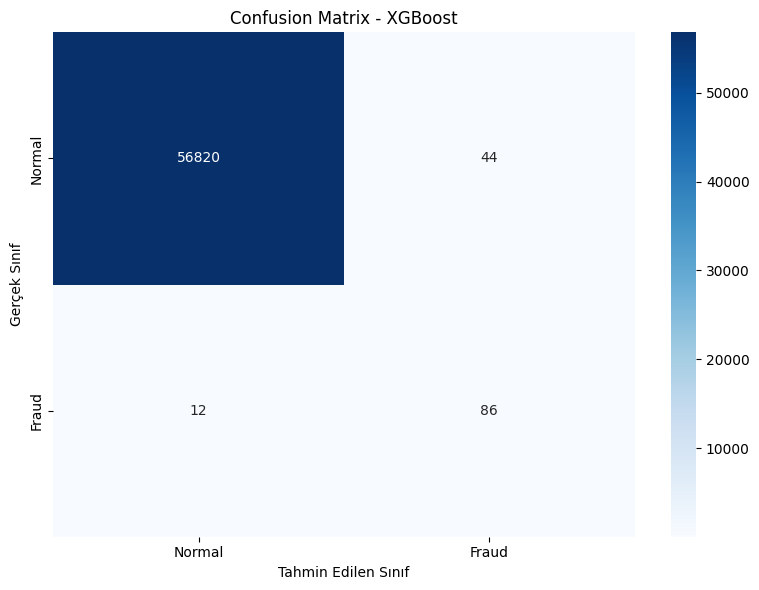

In [53]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

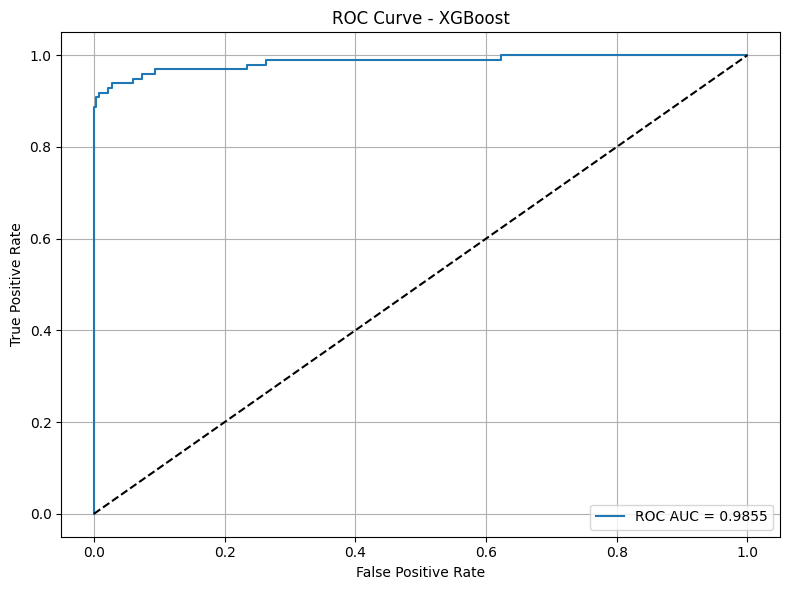

In [54]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, test_probs_xgb)
roc_auc = roc_auc_score(y_test, test_probs_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

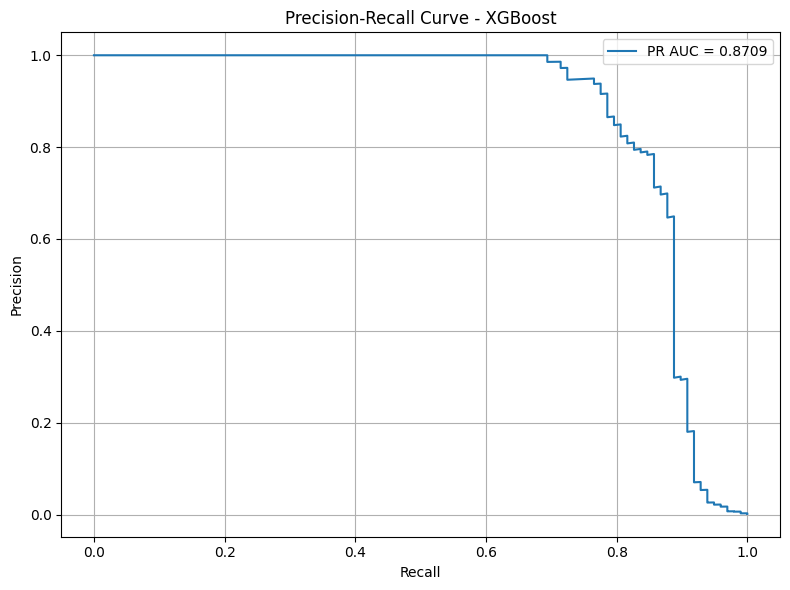

In [55]:
# Precision-Recall Eğrisi
precision, recall, _ = precision_recall_curve(y_test, test_probs_xgb)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
# Sınıflandırma raporu görselleştirmesi
# Rapor metnini DataFrame'e çevirelim
def classification_report_to_dataframe(report_text):
    lines = report_text.split('\n')
    # Başlık satırını ve boş satırları atlayarak veriyi toplama
    data = []
    for line in lines[2:-5]:  # Başlangıç ve sondan boş satırları atla
        if line.strip():
            row = line.strip().split()
            if len(row) >= 5:  # Sınıf, precision, recall, f1-score, support
                class_name = row[0]
                precision = float(row[1])
                recall = float(row[2])
                f1_score = float(row[3])
                support = int(row[4])
                data.append({
                    'class': class_name,
                    'precision': precision,
                    'recall': recall,
                    'f1-score': f1_score,
                    'support': support
                })
    
    # Accuracy, macro avg ve weighted avg için
    for line in lines[-4:-1]:
        if line.strip():
            row = line.strip().split()
            if len(row) >= 5:  # Class adı 2 kelime olabilir
                if row[0] == 'accuracy':
                    class_name = 'accuracy'
                    precision = float('nan')
                    recall = float('nan')
                    f1_score = float(row[1])
                    support = int(row[2])
                else:
                    class_name = row[0] + ' ' + row[1]
                    precision = float(row[2])
                    recall = float(row[3])
                    f1_score = float(row[4])
                    support = int(row[5])
                data.append({
                    'class': class_name,
                    'precision': precision,
                    'recall': recall,
                    'f1-score': f1_score,
                    'support': support
                })
    
    return pd.DataFrame(data)


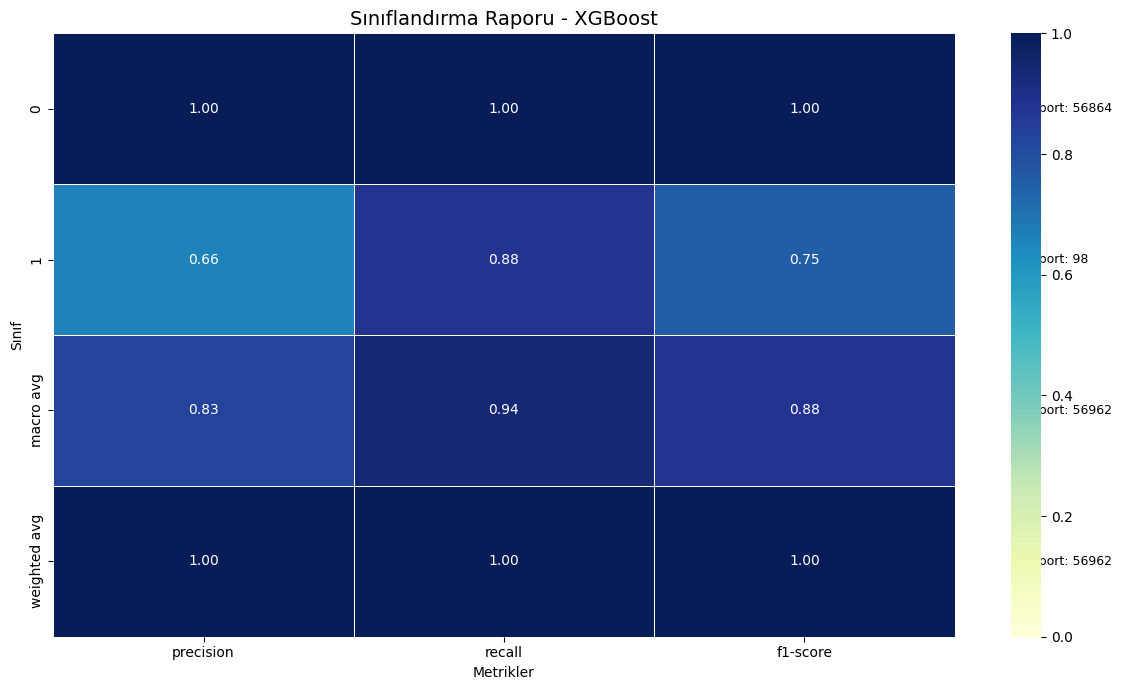

In [57]:
# Sınıflandırma raporunu DataFrame'e çevirelim
report_df = classification_report_to_dataframe(report)

# Başarı metriklerini görselleştirme
plt.figure(figsize=(12, 7))

# Isı haritası için değerleri hazırlayalım
metrics_df = report_df.copy()
metrics_df = metrics_df.set_index('class')
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# NaN değerleri 0 ile dolduralım (görselleştirme için)
metrics_df = metrics_df.fillna(0)

# Isı haritası
ax = sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt='.2f', 
                linewidths=.5, vmin=0, vmax=1)
plt.title('Sınıflandırma Raporu - XGBoost', fontsize=14)
plt.ylabel('Sınıf')
plt.xlabel('Metrikler')

# Support değerlerini ekleyelim
for i, (_, row) in enumerate(report_df.iterrows()):
    plt.text(3.2, i + 0.5, f"Support: {row['support']}", 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


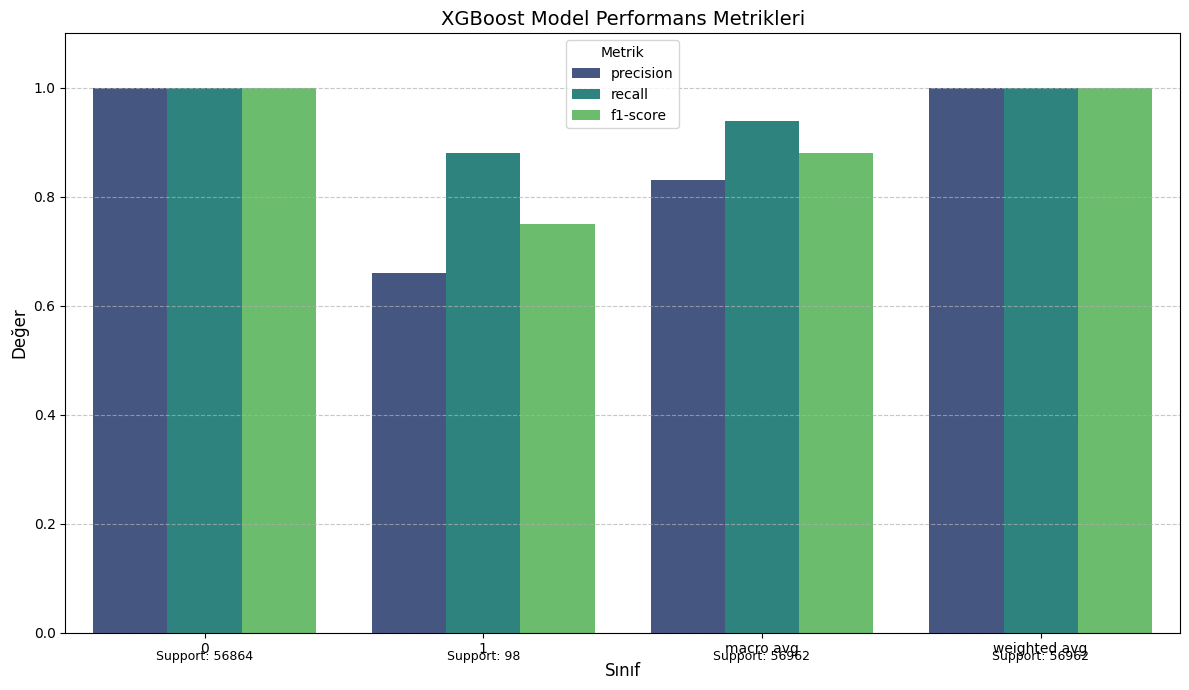

In [58]:
# Metrikleri çubuk grafik olarak gösterme
plt.figure(figsize=(12, 7))

# Uzun format DataFrame'e dönüştürme
metrics_long = pd.melt(report_df, 
                      id_vars=['class', 'support'],
                      value_vars=['precision', 'recall', 'f1-score'],
                      var_name='metric', 
                      value_name='value')

# NaN değerlerini filtreleyebiliriz
metrics_long = metrics_long.dropna(subset=['value'])

# Çubuk grafik
sns.barplot(x='class', y='value', hue='metric', data=metrics_long, palette='viridis')
plt.title('XGBoost Model Performans Metrikleri', fontsize=14)
plt.ylabel('Değer', fontsize=12)
plt.xlabel('Sınıf', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrik')

# Support değerlerini ekleyelim
for i, cls in enumerate(report_df['class'].unique()):
    support = report_df[report_df['class'] == cls]['support'].values[0]
    plt.text(i, -0.05, f"Support: {support}", ha='center', fontsize=9)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# DENEME ALANI

##  Lojistik Regresyon Modeli

2025-05-03 18:16:45,499 | INFO | 3346838185.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:45,499 | INFO | 3346838185.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:45,499 | INFO | 3346838185.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:45,499 | INFO | 3346838185.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:45,501 | INFO | base_model.py:29 | Initialized logistic_regression model
2025-05-03 18:16:45,502 | INFO | logistic_regression.py:36 | Training Logistic Regression model with 68235 samples
2025-05-03 18:16:46,185 | INFO | logistic_regression.py:39 | Logistic Regression model training completed
2025-05-03 18:16:46,186 | INFO | logistic_regression.py:47 | Making predictions on 68235 samples
2025-05-03 18:16:46,202 | INFO | logistic_regression.py:55 | Making probability predictions on 68235 samples
2025-05-03 18:16:46,232 | INFO | logistic_regression.py:47 | Making predictions on 56962 samples
2025-05-03 18:16:46,24


Eğitim Seti Performansı (Lojistik Regresyon):
Accuracy: 0.9775335238513959
Precision: 0.9721331908831908
Recall: 0.9601231039788964
F1 Score: 0.9660908226238138

Test Seti Performansı (Lojistik Regresyon):
Accuracy: 0.9848671043853797
Precision: 0.09361702127659574
Recall: 0.8979591836734694
F1 Score: 0.16955684007707128

Sınıflandırma Raporu (Lojistik Regresyon):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.90      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962



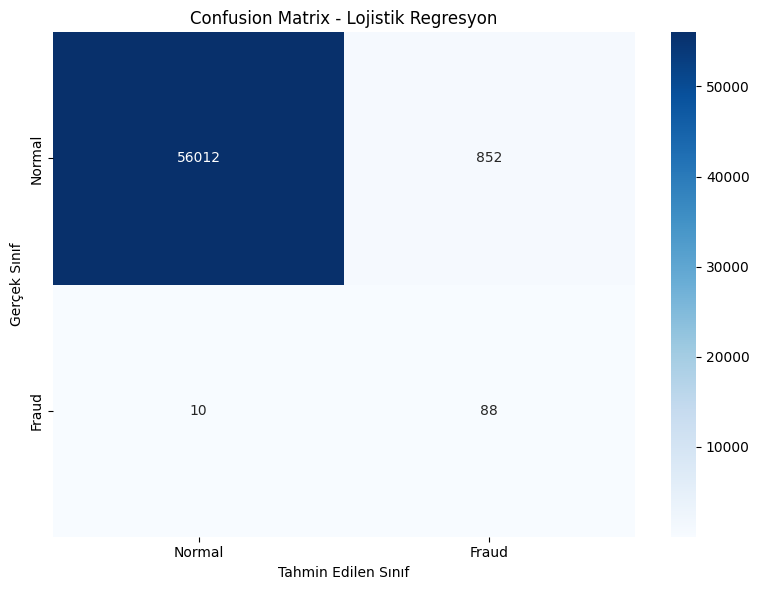

In [59]:
logger.info("Lojistik Regresyon modeli eğitiliyor...")
lr_model = train_logistic_regression(X_train, y_train, LOGISTIC_REGRESSION_PARAMS)

# Eğitim seti üzerinde değerlendirelim
train_preds_lr = lr_model.predict(X_train)
train_probs_lr = lr_model.predict_proba(X_train)[:, 1]

print("\nEğitim Seti Performansı (Lojistik Regresyon):")
print("Accuracy:", accuracy_score(y_train, train_preds_lr))
print("Precision:", precision_score(y_train, train_preds_lr))
print("Recall:", recall_score(y_train, train_preds_lr))
print("F1 Score:", f1_score(y_train, train_preds_lr))

# Test seti üzerinde değerlendirelim
test_preds_lr = lr_model.predict(X_test)
test_probs_lr = lr_model.predict_proba(X_test)[:, 1]

print("\nTest Seti Performansı (Lojistik Regresyon):")
print("Accuracy:", accuracy_score(y_test, test_preds_lr))
print("Precision:", precision_score(y_test, test_preds_lr))
print("Recall:", recall_score(y_test, test_preds_lr))
print("F1 Score:", f1_score(y_test, test_preds_lr))

# Sınıflandırma raporu
print("\nSınıflandırma Raporu (Lojistik Regresyon):")
print(classification_report(y_test, test_preds_lr))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], 
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Lojistik Regresyon')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

# DENEME ALANI

In [60]:
logger.info("Lojistik Regresyon modeli eğitiliyor...")
lr_model = train_logistic_regression(X_train, y_train, LOGISTIC_REGRESSION_PARAMS)

2025-05-03 18:16:46,381 | INFO | 487335719.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:46,381 | INFO | 487335719.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:46,381 | INFO | 487335719.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:46,381 | INFO | 487335719.py:1 | Lojistik Regresyon modeli eğitiliyor...
2025-05-03 18:16:46,382 | INFO | base_model.py:29 | Initialized logistic_regression model
2025-05-03 18:16:46,383 | INFO | logistic_regression.py:36 | Training Logistic Regression model with 68235 samples
2025-05-03 18:16:47,081 | INFO | logistic_regression.py:39 | Logistic Regression model training completed


In [61]:
# Eğitim seti üzerinde değerlendirelim
train_preds_lr = lr_model.predict(X_train)
train_probs_lr = lr_model.predict_proba(X_train)[:, 1]

print("\nEğitim Seti Performansı (Lojistik Regresyon):")
print("Accuracy:", accuracy_score(y_train, train_preds_lr))
print("Precision:", precision_score(y_train, train_preds_lr))
print("Recall:", recall_score(y_train, train_preds_lr))
print("F1 Score:", f1_score(y_train, train_preds_lr))

2025-05-03 18:16:47,088 | INFO | logistic_regression.py:47 | Making predictions on 68235 samples
2025-05-03 18:16:47,105 | INFO | logistic_regression.py:55 | Making probability predictions on 68235 samples



Eğitim Seti Performansı (Lojistik Regresyon):
Accuracy: 0.9775335238513959
Precision: 0.9721331908831908
Recall: 0.9601231039788964
F1 Score: 0.9660908226238138


In [62]:
# Test seti üzerinde değerlendirelim
test_preds_lr = lr_model.predict(X_test)
test_probs_lr = lr_model.predict_proba(X_test)[:, 1]

print("\nTest Seti Performansı (Lojistik Regresyon):")
print("Accuracy:", accuracy_score(y_test, test_preds_lr))
print("Precision:", precision_score(y_test, test_preds_lr))
print("Recall:", recall_score(y_test, test_preds_lr))
print("F1 Score:", f1_score(y_test, test_preds_lr))

2025-05-03 18:16:47,141 | INFO | logistic_regression.py:47 | Making predictions on 56962 samples
2025-05-03 18:16:47,158 | INFO | logistic_regression.py:55 | Making probability predictions on 56962 samples



Test Seti Performansı (Lojistik Regresyon):
Accuracy: 0.9848671043853797
Precision: 0.09361702127659574
Recall: 0.8979591836734694
F1 Score: 0.16955684007707128


In [63]:
# Sınıflandırma raporu
print("\nSınıflandırma Raporu (Lojistik Regresyon):")
report = classification_report(y_test, test_preds_lr)
print(report)


Sınıflandırma Raporu (Lojistik Regresyon):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.09      0.90      0.17        98

    accuracy                           0.98     56962
   macro avg       0.55      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962



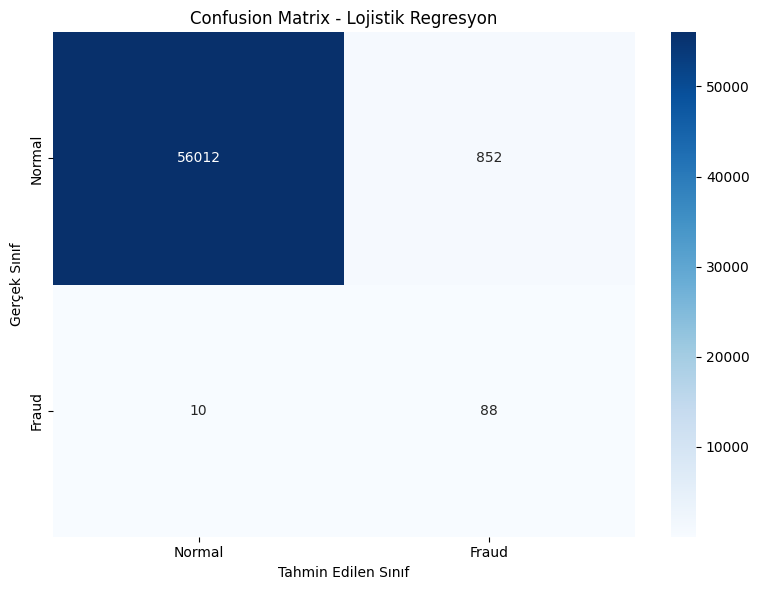

In [64]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Lojistik Regresyon')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

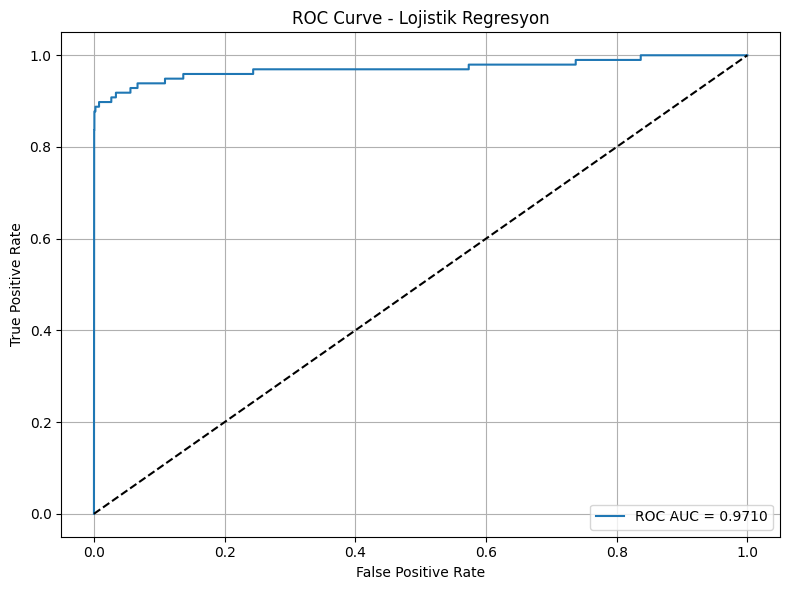

In [65]:
# ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, test_probs_lr)
roc_auc = roc_auc_score(y_test, test_probs_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Lojistik Regresyon')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

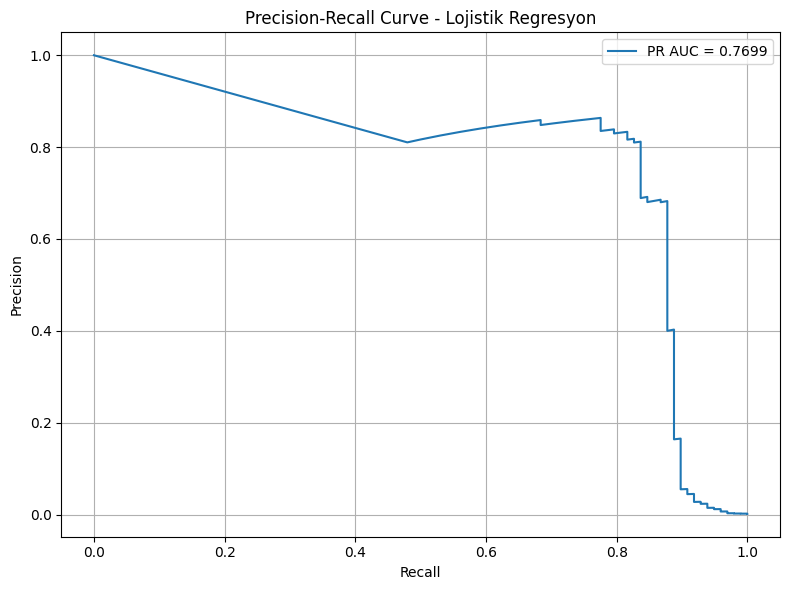

In [66]:
precision, recall, _ = precision_recall_curve(y_test, test_probs_lr)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Lojistik Regresyon')
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# Sınıflandırma raporu görselleştirmesi
# Rapor metnini DataFrame'e çevirelim
def classification_report_to_dataframe(report_text):
    lines = report_text.split('\n')
    # Başlık satırını ve boş satırları atlayarak veriyi toplama
    data = []
    for line in lines[2:-5]:  # Başlangıç ve sondan boş satırları atla
        if line.strip():
            row = line.strip().split()
            if len(row) >= 5:  # Sınıf, precision, recall, f1-score, support
                class_name = row[0]
                precision = float(row[1])
                recall = float(row[2])
                f1_score = float(row[3])
                support = int(row[4])
                data.append({
                    'class': class_name,
                    'precision': precision,
                    'recall': recall,
                    'f1-score': f1_score,
                    'support': support
                })
    
    # Accuracy, macro avg ve weighted avg için
    for line in lines[-4:-1]:
        if line.strip():
            row = line.strip().split()
            if len(row) >= 5:  # Class adı 2 kelime olabilir
                if row[0] == 'accuracy':
                    class_name = 'accuracy'
                    precision = float('nan')
                    recall = float('nan')
                    f1_score = float(row[1])
                    support = int(row[2])
                else:
                    class_name = row[0] + ' ' + row[1]
                    precision = float(row[2])
                    recall = float(row[3])
                    f1_score = float(row[4])
                    support = int(row[5])
                data.append({
                    'class': class_name,
                    'precision': precision,
                    'recall': recall,
                    'f1-score': f1_score,
                    'support': support
                })
    
    return pd.DataFrame(data)


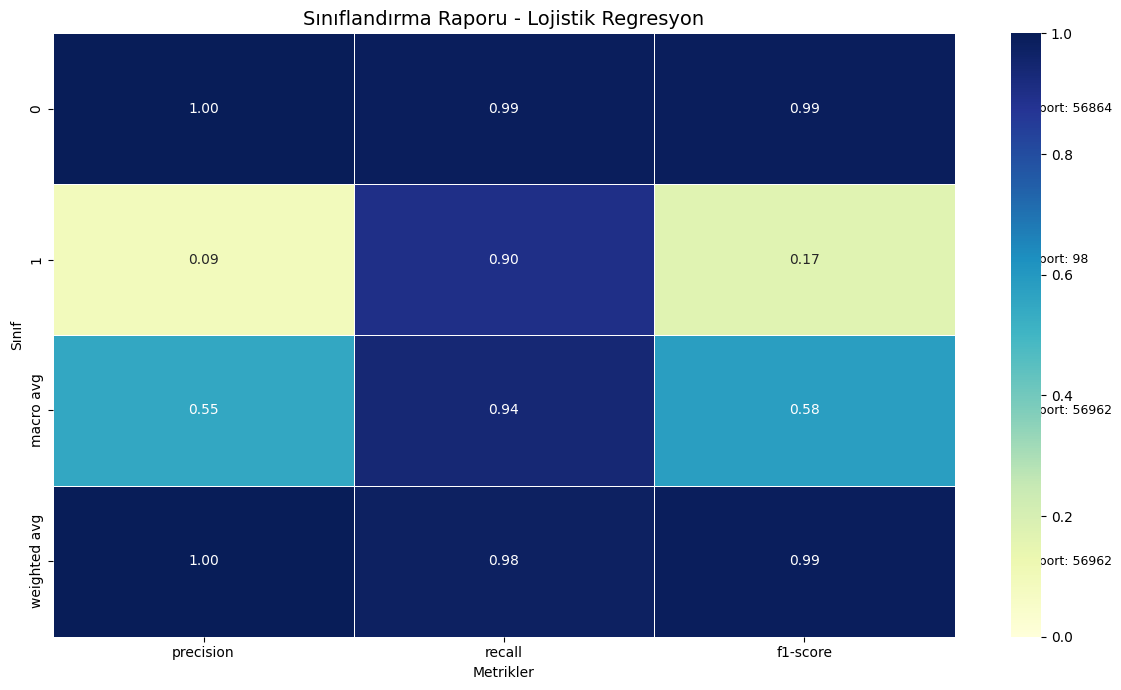

In [68]:
# Sınıflandırma raporunu DataFrame'e çevirelim
report_df = classification_report_to_dataframe(report)

# Başarı metriklerini görselleştirme
plt.figure(figsize=(12, 7))

# Isı haritası için değerleri hazırlayalım
metrics_df = report_df.copy()
metrics_df = metrics_df.set_index('class')
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# NaN değerleri 0 ile dolduralım (görselleştirme için)
metrics_df = metrics_df.fillna(0)

# Isı haritası
ax = sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt='.2f', 
                linewidths=.5, vmin=0, vmax=1)
plt.title('Sınıflandırma Raporu - Lojistik Regresyon', fontsize=14)
plt.ylabel('Sınıf')
plt.xlabel('Metrikler')

# Support değerlerini ekleyelim
for i, (_, row) in enumerate(report_df.iterrows()):
    plt.text(3.2, i + 0.5, f"Support: {row['support']}", 
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

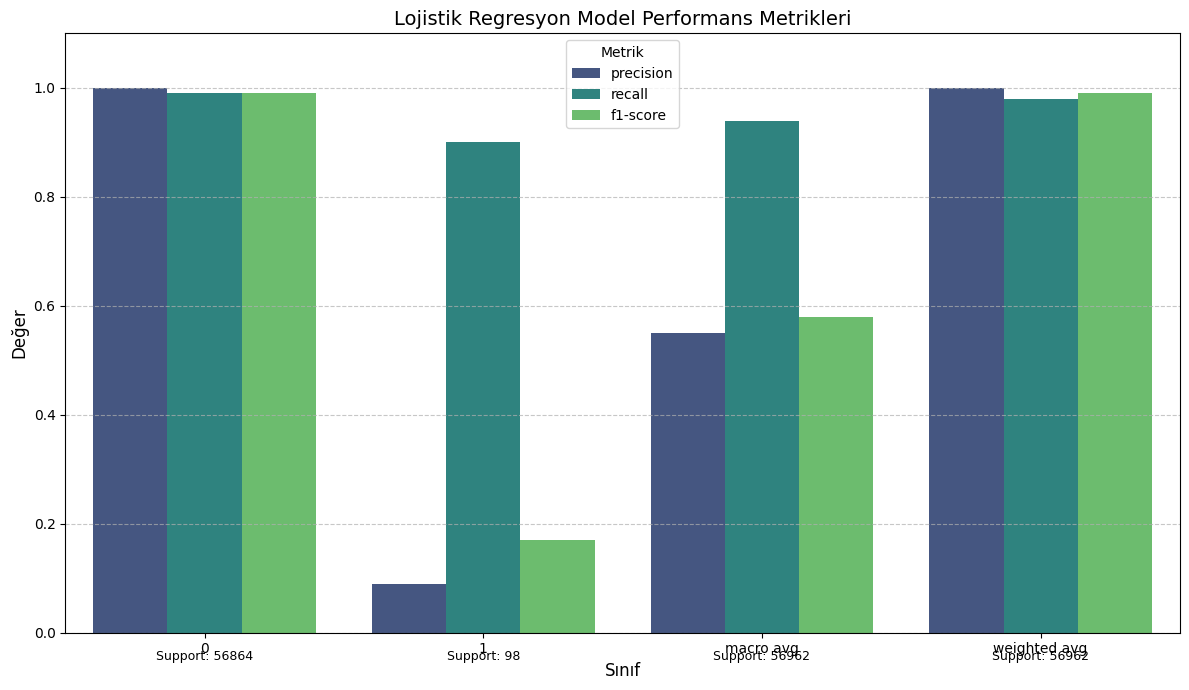

In [69]:
# Metrikleri çubuk grafik olarak gösterme
plt.figure(figsize=(12, 7))

# Uzun format DataFrame'e dönüştürme
metrics_long = pd.melt(report_df, 
                      id_vars=['class', 'support'],
                      value_vars=['precision', 'recall', 'f1-score'],
                      var_name='metric', 
                      value_name='value')

# NaN değerlerini filtreleyebiliriz
metrics_long = metrics_long.dropna(subset=['value'])

# Çubuk grafik
sns.barplot(x='class', y='value', hue='metric', data=metrics_long, palette='viridis')
plt.title('Lojistik Regresyon Model Performans Metrikleri', fontsize=14)
plt.ylabel('Değer', fontsize=12)
plt.xlabel('Sınıf', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metrik')

# Support değerlerini ekleyelim
for i, cls in enumerate(report_df['class'].unique()):
    support = report_df[report_df['class'] == cls]['support'].values[0]
    plt.text(i, -0.05, f"Support: {support}", ha='center', fontsize=9)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# DENEME ALANI

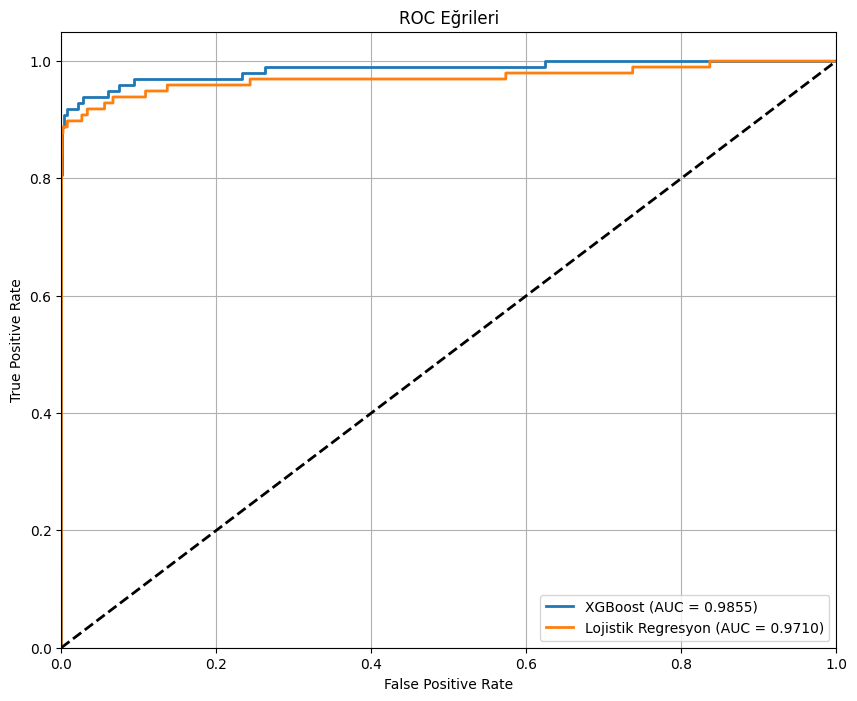

In [70]:
plt.figure(figsize=(10, 8))

# XGBoost için ROC eğrisi
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, test_probs_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})')

# Lojistik Regresyon için ROC eğrisi
fpr_lr, tpr_lr, _ = roc_curve(y_test, test_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Lojistik Regresyon (AUC = {roc_auc_lr:.4f})')

# Tesadüfi tahmin için çizgi
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

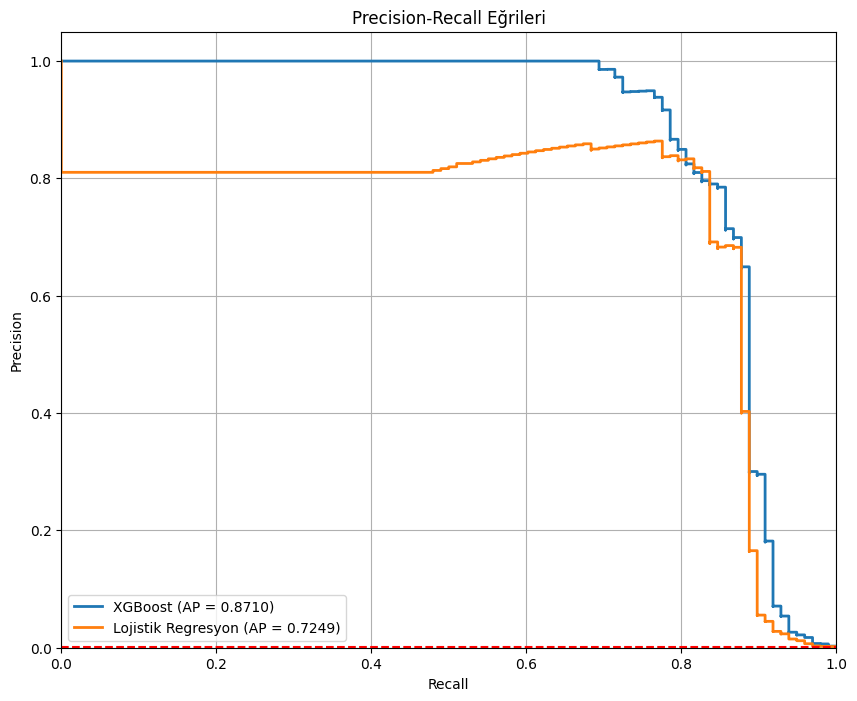

In [71]:
# Precision-Recall eğrilerini çizelim
plt.figure(figsize=(10, 8))

# XGBoost için PR eğrisi
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, test_probs_xgb)
avg_precision_xgb = average_precision_score(y_test, test_probs_xgb)
plt.step(recall_xgb, precision_xgb, where='post', lw=2, 
         label=f'XGBoost (AP = {avg_precision_xgb:.4f})')

# Lojistik Regresyon için PR eğrisi
precision_lr, recall_lr, _ = precision_recall_curve(y_test, test_probs_lr)
avg_precision_lr = average_precision_score(y_test, test_probs_lr)
plt.step(recall_lr, precision_lr, where='post', lw=2, 
         label=f'Lojistik Regresyon (AP = {avg_precision_lr:.4f})')

# Rastgele sınıflandırıcı için çizgi (veri setinin ortalama pozitif oranı)
plt.axhline(y=np.mean(y_test), linestyle='--', color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Eğrileri')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [72]:
# XGBoost modeli için özellik önemini alalım
feature_importance = preprocessor.get_feature_importance(X_train.columns.tolist(), xgb_model)

# Özellik önemini görselleştirelim
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('En Önemli 20 Özellik')
plt.tight_layout()
plt.show()

2025-05-03 18:16:48,305 | WARNING | pipeline.py:160 | Model doesn't have feature_importances_ attribute


AttributeError: 'NoneType' object has no attribute 'head'

<Figure size 1200x1000 with 0 Axes>

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# RandomizedSearchCV kullanarak hiperparametre optimizasyonu yapalım
# (GridSearchCV yerine daha hızlı olması için)
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=50,  # Dengesiz veri seti için
    random_state=RANDOM_STATE
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,  # 10 farklı kombinasyon deneyelim
    scoring='f1',  # F1 skoruna göre optimize edelim
    cv=3,  # 3-fold cross validation
    random_state=RANDOM_STATE,
    n_jobs=-1  # Tüm CPU çekirdeklerini kullan
)

random_search.fit(X_train, y_train)

# En iyi parametreleri görelim
print("En İyi Parametreler:")
print(random_search.best_params_)
print("\nEn İyi F1 Skoru:")
print(random_search.best_score_)

# En iyi modeli alalım
best_xgb_model = random_search.best_estimator_

#Test seti üzerinde değerlendirelim
best_test_preds = best_xgb_model.predict(X_test)
print("\nTest Seti Performansı (En İyi XGBoost):")
print("F1 Score:", f1_score(y_test, best_test_preds))
print("Sınıflandırma Raporu:")
print(classification_report(y_test, best_test_preds))

In [ ]:
thresholds = np.arange(0, 1, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for threshold in thresholds:
    # Verilen eşik değerine göre tahminleri oluştur
    y_pred = (test_probs_xgb >= threshold).astype(int)
    
    # Metrikleri hesapla
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Sonuçları görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=0.5, color='r', linestyle='--', label='Default Threshold (0.5)')

# En yüksek F1 skoruna sahip eşik değerini bulalım
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]
plt.axvline(x=optimal_threshold, color='g', linestyle='--', 
            label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.title('Eşik Değerine Göre Metrik Değişimi')
plt.xlabel('Eşik Değeri')
plt.ylabel('Skor')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimum eşik değeri: {optimal_threshold:.2f}")
print(f"Bu eşik değerinde F1: {f1_scores[optimal_threshold_idx]:.4f}")
print(f"Bu eşik değerinde Precision: {precision_scores[optimal_threshold_idx]:.4f}")
print(f"Bu eşik değerinde Recall: {recall_scores[optimal_threshold_idx]:.4f}")

In [ ]:
# Modelleri kaydedelim
os.makedirs(MODELS_DIR, exist_ok=True)

# XGBoost modelini kaydet
xgb_path = os.path.join(MODELS_DIR, 'xgboost_v1.pkl')
with open(xgb_path, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"XGBoost modeli kaydedildi: {xgb_path}")

# Lojistik Regresyon modelini kaydet
lr_path = os.path.join(MODELS_DIR, 'logistic_regression_v1.pkl')
with open(lr_path, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"Lojistik Regresyon modeli kaydedildi: {lr_path}")

# Optimum eşik değerini de kaydedelim
threshold_info = {
    'optimum_threshold': optimal_threshold,
    'default_threshold': 0.5,
    'metrics': {
        'optimum_f1': f1_scores[optimal_threshold_idx],
        'optimum_precision': precision_scores[optimal_threshold_idx],
        'optimum_recall': recall_scores[optimal_threshold_idx]
    }
}

threshold_path = os.path.join(MODELS_DIR, 'threshold_info.pkl')
with open(threshold_path, 'wb') as f:
    pickle.dump(threshold_info, f)
print(f"Eşik değeri bilgileri kaydedildi: {threshold_path}")

In [ ]:
# Sonuçları özetleyelim
print("Model Eğitimi ve Değerlendirme Özeti:")
print("-" * 50)
print(f"Eğitim Seti Boyutu: {X_train.shape} ({X_train.shape[0]} örnek, {X_train.shape[1]} özellik)")
print(f"Test Seti Boyutu: {X_test.shape} ({X_test.shape[0]} örnek, {X_test.shape[1]} özellik)")
print("-" * 50)
print("XGBoost Performansı (Test Seti):")
print(f"F1 Skoru (Default 0.5): {f1_score(y_test, test_preds_xgb):.4f}")
print(f"F1 Skoru (Optimum {optimal_threshold:.2f}): {f1_scores[optimal_threshold_idx]:.4f}")
print(f"AUC: {roc_auc_xgb:.4f}")
print("-" * 50)
print("Lojistik Regresyon Performansı (Test Seti):")
print(f"F1 Skoru: {f1_score(y_test, test_preds_lr):.4f}")
print(f"AUC: {roc_auc_lr:.4f}")
print("-" * 50)
print("En Önemli 5 Özellik:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")